In [12]:
!pip install -U scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import requests
from io import StringIO

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/soybean/soybean-small.data"
response = requests.get(url)
data = StringIO(response.text)

column_names = ['class', 'date', 'plant-stand', 'precip', 'temp', 'hail', 'crop-hist', 'area-damaged',
                'severity', 'seed-tmt', 'germination', 'plant-growth', 'leaves', 'leafspots-halo',
                'leafspots-marg', 'leafspot-size', 'leaf-shread', 'leaf-malf', 'leaf-mild', 'stem',
                'lodging', 'stem-cankers', 'canker-lesion', 'fruiting-bodies', 'external-decay',
                'mycelium', 'int-discolor', 'sclerotia', 'fruit-pods', 'fruit-spots', 'seed',
                'mold-growth', 'seed-discolor', 'seed-size', 'shriveling', 'roots']

df = pd.read_csv(data, header=None, names=column_names, na_values='?')

print(f"Forma del dataset: {df.shape}")
print(f"Valores faltantes por columna:\n{df.isnull().sum()}")

for column in df.columns:
    if df[column].isnull().any():
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)

label_encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

X = df.drop('class', axis=1)
y = df['class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Datos cargados y preprocesados correctamente.")

Forma del dataset: (47, 36)
Valores faltantes por columna:
class              0
date               0
plant-stand        0
precip             0
temp               0
hail               0
crop-hist          0
area-damaged       0
severity           0
seed-tmt           0
germination        0
plant-growth       0
leaves             0
leafspots-halo     0
leafspots-marg     0
leafspot-size      0
leaf-shread        0
leaf-malf          0
leaf-mild          0
stem               0
lodging            0
stem-cankers       0
canker-lesion      0
fruiting-bodies    0
external-decay     0
mycelium           0
int-discolor       0
sclerotia          0
fruit-pods         0
fruit-spots        0
seed               0
mold-growth        0
seed-discolor      0
seed-size          0
shriveling         0
roots              0
dtype: int64
Datos cargados y preprocesados correctamente.


Distribución de clases:
class
0    10
3     9
2     7
6     6
4     5
5     5
1     5
Name: count, dtype: int64
Tamaño de la clase más pequeña: 5
Usando 3 pliegues para validación cruzada
Mejores parámetros: {'C': 10, 'kernel': 'rbf'}

Evaluación del modelo SVM:
  Accuracy: 0.5000
  Precision: 0.3500
  Recall: 0.5000
  F1-Score: 0.3971


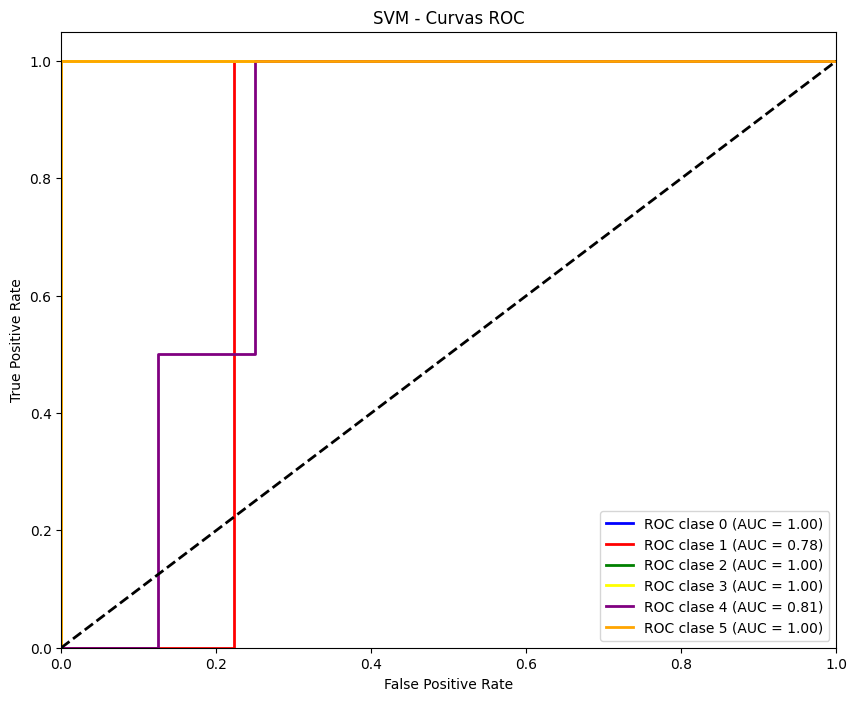

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import cycle

class_counts = pd.Series(y).value_counts()
print("Distribución de clases:")
print(class_counts)

min_class_size = class_counts.min()
print(f"Tamaño de la clase más pequeña: {min_class_size}")

n_splits = min(min_class_size, 3)
print(f"Usando {n_splits} pliegues para validación cruzada")

svm = SVC(probability=True, class_weight='balanced')


param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

grid_search_svm = GridSearchCV(svm, param_grid_svm, scoring='f1_weighted', cv=cv_strategy)
grid_search_svm.fit(X_train, y_train)  

print(f"Mejores parámetros: {grid_search_svm.best_params_}")

best_svm = grid_search_svm.best_estimator_

# Predicciones
y_pred_svm = best_svm.predict(X_test)

# Métricas de evaluación con manejo de zero_division
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
recall_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
fscore_svm = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)

# Mostrar resultados
print(f"\nEvaluación del modelo SVM:")
print(f"  Accuracy: {accuracy_svm:.4f}")
print(f"  Precision: {precision_svm:.4f}")
print(f"  Recall: {recall_svm:.4f}")
print(f"  F1-Score: {fscore_svm:.4f}")

# Para el cálculo de ROC, verificar si es posible calcularlo
try:
    # Binarizar las etiquetas
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    # Si solo hay dos clases, ajustar formato
    if len(classes) == 2:
        y_test_bin = np.hstack((1-y_test_bin, y_test_bin))

    # Calcular probabilidades
    y_score = best_svm.predict_proba(X_test)

    # Configurar el gráfico
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'yellow', 'purple', 'orange'])

    # Calcular y graficar ROC para cada clase
    for i, (color, cls) in enumerate(zip(colors, classes)):
        if i < y_test_bin.shape[1]:  # Asegurarse de que el índice es válido
            try:
                # Verificar si hay muestras positivas
                if np.sum(y_test_bin[:, i]) > 0:
                    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, color=color, lw=2,
                            label=f'ROC clase {cls} (AUC = {roc_auc:.2f})')
                else:
                    print(f"No hay muestras positivas para la clase {cls}, saltando cálculo ROC")
            except Exception as e:
                print(f"Error al calcular ROC para clase {cls}: {e}")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('SVM - Curvas ROC')
    plt.legend(loc="lower right")
    plt.show()
except Exception as e:
    print(f"Error al calcular las curvas ROC: {e}")
    print("El cálculo de ROC puede no ser posible con la distribución actual de clases.")

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Mejores parámetros encontrados: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10}

Evaluación del modelo Decision Tree:
  Accuracy: 0.3333
  Precision: 0.2741
  Recall: 0.3333
  F1-Score: 0.2618


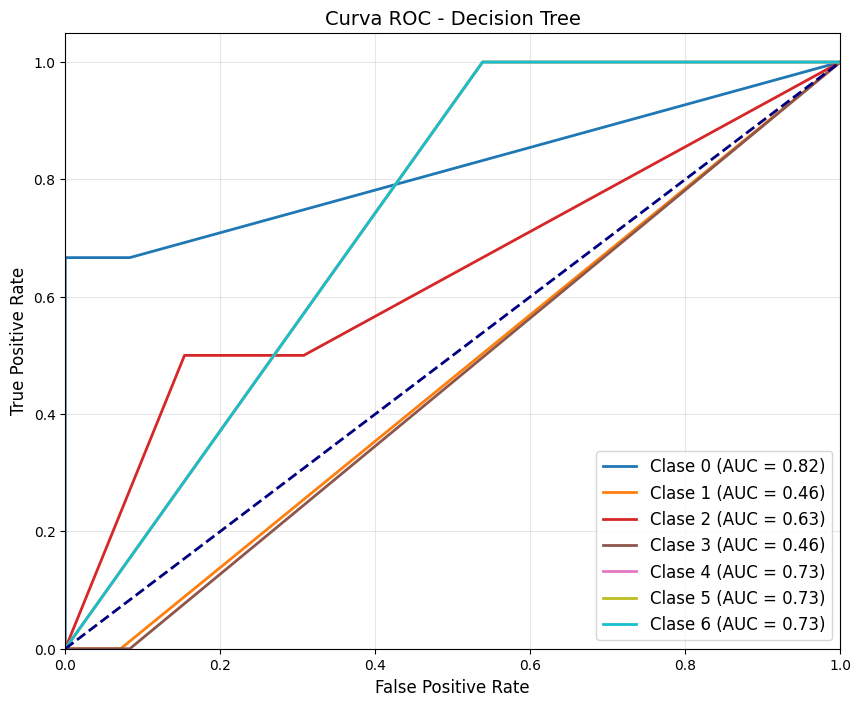

In [30]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score, roc_curve, auc)
import matplotlib.pyplot as plt
import matplotlib as mpl  # Para acceder a los colormaps de forma correcta

# Definir el modelo Decision Tree
dtc = DecisionTreeClassifier(random_state=42)  # Añadido random_state para reproducibilidad

# Definir los parámetros para GridSearchCV
param_grid_dtc = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']  # Añadido criterio de división
}

# Realizar GridSearchCV con más opciones
grid_search_dtc = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid_dtc,
    scoring='f1_weighted',  # Cambiado a 'weighted' para multiclase
    cv=5,
    n_jobs=-1,  # Paralelizar la búsqueda
    verbose=1  # Mostrar progreso
)

grid_search_dtc.fit(X_train, y_train)

# Obtener el mejor modelo Decision Tree
best_dtc = grid_search_dtc.best_estimator_
print(f"\nMejores parámetros encontrados: {grid_search_dtc.best_params_}")

# Predicciones
y_pred_dtc = best_dtc.predict(X_test)
y_proba_dtc = best_dtc.predict_proba(X_test)  # Probabilidades para ROC

# Métricas de evaluación
accuracy_dtc = accuracy_score(y_test, y_pred_dtc)
precision_dtc = precision_score(y_test, y_pred_dtc, average='weighted')
recall_dtc = recall_score(y_test, y_pred_dtc, average='weighted')
fscore_dtc = f1_score(y_test, y_pred_dtc, average='weighted')

# Mostrar resultados de forma más completa
print("\nEvaluación del modelo Decision Tree:")
print(f"  Accuracy: {accuracy_dtc:.4f}")
print(f"  Precision: {precision_dtc:.4f}")
print(f"  Recall: {recall_dtc:.4f}")
print(f"  F1-Score: {fscore_dtc:.4f}")

# Calcular la curva ROC y AUC (para cada clase en problemas multiclase)
n_classes = len(np.unique(y_test))  # Número de clases
fpr_dtc = {}
tpr_dtc = {}
roc_auc_dtc = {}

for i in range(n_classes):
    fpr_dtc[i], tpr_dtc[i], _ = roc_curve(y_test == i, y_proba_dtc[:, i])
    roc_auc_dtc[i] = auc(fpr_dtc[i], tpr_dtc[i])

# Graficar la curva ROC para cada clase
plt.figure(figsize=(10, 8))

# Acceder al colormap de forma actualizada
colors = mpl.colormaps['tab10'](np.linspace(0, 1, n_classes))  # Nueva forma recomendada

for i in range(n_classes):
    plt.plot(fpr_dtc[i], tpr_dtc[i], color=colors[i], lw=2, label=f'Clase {i} (AUC = {roc_auc_dtc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curva ROC - Decision Tree', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


Evaluación del modelo Random Forest:
  Accuracy: 0.3333
  Precision: 0.3778
  Recall: 0.3333
  F1-Score: 0.3422


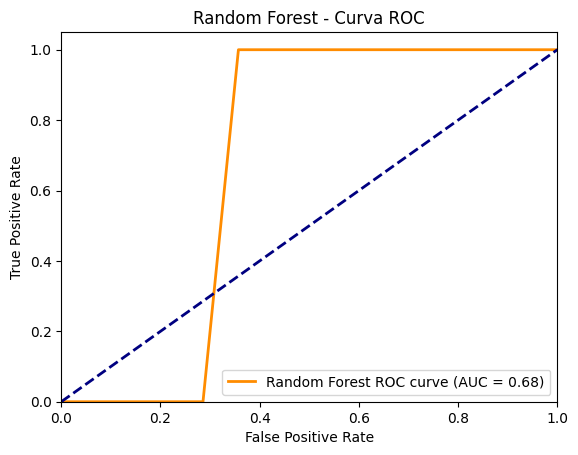

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Definir el modelo Random Forest
rfc = RandomForestClassifier()

# Definir los parámetros para GridSearchCV
param_grid_rfc = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}

# Realizar GridSearchCV
grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, scoring='f1', cv=5)
grid_search_rfc.fit(X_train, y_train)

# Obtener el mejor modelo Random Forest
best_rfc = grid_search_rfc.best_estimator_

# Predicciones
y_pred_rfc = best_rfc.predict(X_test)

# Métricas de evaluación
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
precision_rfc = precision_score(y_test, y_pred_rfc, average='weighted')
recall_rfc = recall_score(y_test, y_pred_rfc, average='weighted')
fscore_rfc = f1_score(y_test, y_pred_rfc, average='weighted')

# Mostrar resultados
print(f"\nEvaluación del modelo Random Forest:")
print(f"  Accuracy: {accuracy_rfc:.4f}")
print(f"  Precision: {precision_rfc:.4f}")
print(f"  Recall: {recall_rfc:.4f}")
print(f"  F1-Score: {fscore_rfc:.4f}")

# Calcular la curva ROC y AUC
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, best_rfc.predict_proba(X_test)[:, 1], pos_label=1)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr_rfc, tpr_rfc, color='darkorange', lw=2, label=f'Random Forest ROC curve (AUC = {roc_auc_rfc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Curva ROC')
plt.legend(loc='lower right')
plt.show()


Evaluación del modelo Extra Trees:
  Accuracy: 0.2667
  Precision: 0.2667
  Recall: 0.2667
  F1-Score: 0.2667


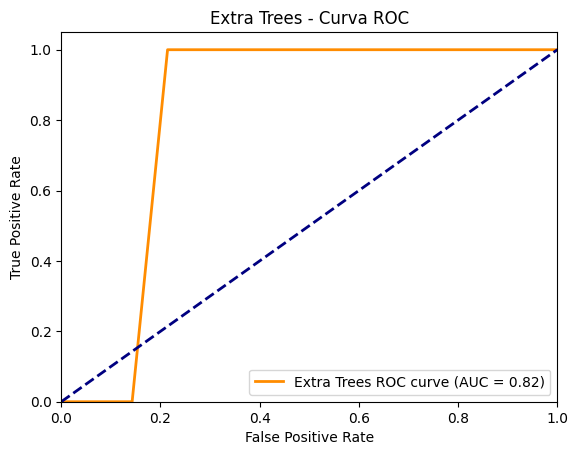

In [28]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Definir el modelo Extra Trees
etc = ExtraTreesClassifier()

# Definir los parámetros para GridSearchCV
param_grid_etc = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}

# Realizar GridSearchCV
grid_search_etc = GridSearchCV(etc, param_grid_etc, scoring='f1', cv=5)
grid_search_etc.fit(X_train, y_train)

# Obtener el mejor modelo Extra Trees
best_etc = grid_search_etc.best_estimator_

# Predicciones
y_pred_etc = best_etc.predict(X_test)

# Métricas de evaluación
accuracy_etc = accuracy_score(y_test, y_pred_etc)
precision_etc = precision_score(y_test, y_pred_etc, average='weighted')
recall_etc = recall_score(y_test, y_pred_etc, average='weighted')
fscore_etc = f1_score(y_test, y_pred_etc, average='weighted')

# Mostrar resultados
print(f"\nEvaluación del modelo Extra Trees:")
print(f"  Accuracy: {accuracy_etc:.4f}")
print(f"  Precision: {precision_etc:.4f}")
print(f"  Recall: {recall_etc:.4f}")
print(f"  F1-Score: {fscore_etc:.4f}")

# Calcular la curva ROC y AUC
fpr_etc, tpr_etc, thresholds_etc = roc_curve(y_test, best_etc.predict_proba(X_test)[:, 1], pos_label=1)
roc_auc_etc = auc(fpr_etc, tpr_etc)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr_etc, tpr_etc, color='darkorange', lw=2, label=f'Extra Trees ROC curve (AUC = {roc_auc_etc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extra Trees - Curva ROC')
plt.legend(loc='lower right')
plt.show()